In [1]:
import os
import torch
import random
from torch.utils import data
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from unet import UNet
from diffusion import GaussianDiffusion, Trainer, Dataset

## Dataloader

In [8]:
class Dataset(data.Dataset):
    def __init__(self, folder, image_size, mode):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.mode = mode

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ])
        
    def __len__(self):
        dir_path = self.folder+"data/"
        res = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
        return res

    def irregular_mask(self, data, rate=0.5):
        """the mask matrix of random sampling
        Args:
            data: original data patches
            rate: sampling rate,range(0,1)
        """
        n = data.size()[-2]
        mask = torch.torch.zeros(data.size(),dtype=torch.float64)
        v = round(n*rate)
        TM = random.sample(range(n),v)
        mask[:,TM,:]=1 # missing by column 
        mask = mask.type(torch.FloatTensor)
        return  mask

    def __getitem__(self, index):

        data = self.folder+"data/"+str(index)+".png"
        img_data = Image.open(data)

        if self.mode == "demultiple":
            label = self.folder+"labels/"+str(index)+".png"
            img_label = Image.open(label)
            return self.transform(img_data), self.transform(img_label)
        elif self.mode == "interpolation":
            return self.irregular_mask(self.transform(img_data)), self.transform(img_data)
        elif self.mode == "denoising":
            img = self.transform(img_data)
            mean = torch.mean(img)
            std = torch.std(img)
            noise = 0.5*torch.normal(mean, std, size =(img.shape[0], img.shape[1], img.shape[2]))
            img_ = img + noise
            return img_, img  
        else:
            print("ERROR MODE DATASET")

## Create Model

In [13]:
mode = "demultiple" #demultiple, interpolation, denoising
# folder = './dataset/'+mode+'/data_train/'
folder = 'dataset/'+mode+'/data_test_5sample_npy/'

image_size = (64,256)
    
model = UNet(
        in_channel=2,
        out_channel=1,
        dropout=0.5,
        image_size = 256,
        # attn_res=[64, 16]
).to("mps")#.cuda()

diffusion = GaussianDiffusion(
    model,
    mode = mode,
    channels = 1,
    image_size = image_size,
    timesteps = 768,
    loss_type = 'l2', # L1 or L2
    noise_mix_ratio = None
).to("mps")#.cuda()

ds = Dataset(folder, image_size=image_size, mode=mode, file_ext='.npy')

In [14]:
from torchsummary import summary
from torch import nn

class UNetWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = UNet(
                in_channel=2,
                out_channel=1,
                dropout=0.5,
                image_size = 256,
        )
        
    def forward(self, x):
        # Create a dummy time tensor with the same batch size as input
        batch_size = x.shape[0]
        time = torch.zeros(batch_size, device=x.device)
        return self.model(x, time)

# Wrap the model
wrapped_model = UNetWrapper(model)

# Now use torchsummary
summary(wrapped_model, input_size=(2, 64, 256))

# summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
PositionalEncoding-1                   [-1, 64]               0
            Linear-2                  [-1, 256]          16,640
             Swish-3                  [-1, 256]               0
            Linear-4                   [-1, 64]          16,448
            Conv2d-5          [-1, 64, 64, 256]           1,216
         GroupNorm-6          [-1, 64, 64, 256]             128
             Swish-7          [-1, 64, 64, 256]               0
          Identity-8          [-1, 64, 64, 256]               0
            Conv2d-9          [-1, 64, 64, 256]          36,928
            Block-10          [-1, 64, 64, 256]               0
           Linear-11                   [-1, 64]           4,160
FeatureWiseAffine-12          [-1, 64, 64, 256]               0
        GroupNorm-13          [-1, 64, 64, 256]             128
            Swish-14          [-1, 64, 

## Load Model

In [14]:
# parameters = torch.load("results_demultiple/model-4.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results/results_demultiple/model-4.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation/model-9.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation_0106-es4/model-5.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation_0106/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results/results_demultiple/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_demultiple_0107-es4/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_demultiple_0107-es4/model-5.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_demultiple_0107-es4/model-9.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_interpolation/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_tmp/model-1.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_tmp/no_filt.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results/demultiple_0110-20k_step1k/model-final.pt", map_location=torch.device('mps'))['model']
# parameters = torch.load("results_tmp/waveform-2.pt", map_location=torch.device('mps'))['model']
parameters = torch.load("results/demultiple0116-waveform/model-final.pt", map_location=torch.device('mps'))['model']


del parameters['betas']
del parameters['alphas_cumprod']
del parameters['alphas_cumprod_prev']
del parameters['sqrt_alphas_cumprod']
del parameters['sqrt_one_minus_alphas_cumprod']
del parameters['log_one_minus_alphas_cumprod']
del parameters['sqrt_recip_alphas_cumprod']
del parameters['sqrt_recipm1_alphas_cumprod']
del parameters['posterior_variance']
del parameters['posterior_log_variance_clipped']
del parameters['posterior_mean_coef1']
del parameters['posterior_mean_coef2']


def change_key(self, old, new):
    #copy = self.copy()
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v
        
keys = []
for key, value in parameters.items():
    keys.append(key)
    
for i in range(len(keys)):
    change_key(parameters, keys[i], keys[i][11:])
    
model.load_state_dict(parameters)

/var/folders/2r/scd6f2h9659__5_241brfhqh0000gn/T/ipykernel_64237/1266285394.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load("results/demultiple0

<All keys matched successfully>

In [15]:
num = 5
in_samples = np.zeros([num,image_size[0],image_size[1]])
out_samples = np.zeros([num,image_size[0],image_size[1]])
truth_samples = np.zeros([num,image_size[0],image_size[1]])

for i, (x_in) in enumerate(ds):
    x_start = x_in[0]
    x_start = torch.unsqueeze(x_start, dim=0)
    x_ = x_in[1]
    x_ = torch.unsqueeze(x_, dim=0)

    if mode == "interpolation":
        out = diffusion.inference(x_in=x_.to("mps"), mask=x_start.to("mps"))
    else:
        out = diffusion.inference(x_in=x_start.to("mps"))
        

    in_samples[i] = out[0,0].cpu().detach().numpy()
    out_samples[i] = out[1,0].cpu().detach().numpy()
    truth_samples[i] = x_in[1]
    if mode == "interpolation":
        out_samples[i] = out[2,0].cpu().detach().numpy()
    
    if i == num-1:
        break

sampling loop time step: 100%|██████████| 768/768 [00:26<00:00, 29.11it/s]
/var/folders/2r/scd6f2h9659__5_241brfhqh0000gn/T/ipykernel_64237/649869250.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  truth_samples[i] = x_in[1]
sampling loop time step: 100%|██████████| 768/768 [00:28<00:00, 26.87it/s]


## Plotting

In [8]:
from scipy.signal import butter, filtfilt

def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    b, a = butter(poles, cutoff, 'highpass', fs=sample_rate)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

x2offsets = lambda x_list: [x[0,:] for x in x_list]

noise = torch.randn(x_in[0].shape)[0]

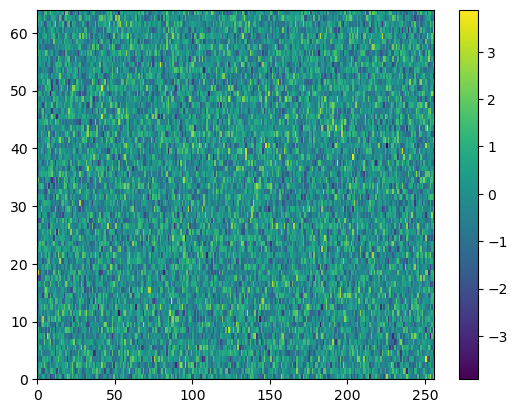

In [15]:
plt.pcolormesh(noise)
plt.colorbar() 

/var/folders/2r/scd6f2h9659__5_241brfhqh0000gn/T/ipykernel_64237/1953874910.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


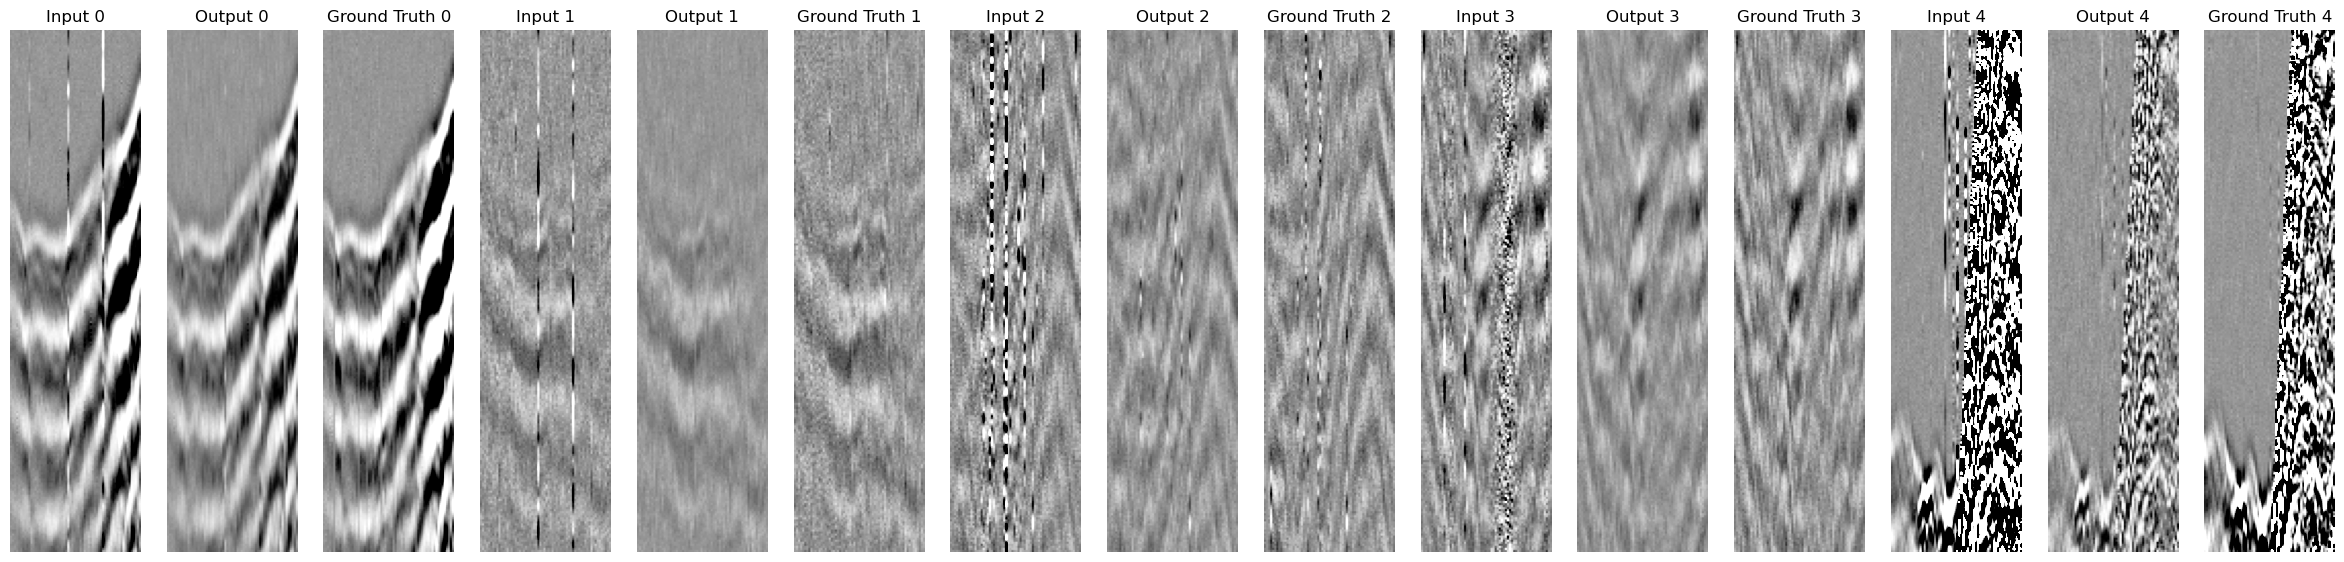

In [16]:
fig, axs = plt.subplots(1,3* num, figsize=(num*6,8))

cont = 0
for i in range(num):
    max_ = 1#in_samples[i].max()
    min_ = -1#in_samples[i].min()
    axs[cont].imshow(in_samples[i].T, vmin=min_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(out_samples[i].T, vmin=min_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Output "+str(i))
    cont = cont+1
    axs[cont].imshow(truth_samples[i].T, vmin=min_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Ground Truth "+str(i))
    cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]
fig.show()

In [10]:
num = 1
in_samples = np.zeros([num,image_size[0],image_size[1]])
out_samples = np.zeros([num,image_size[0],image_size[1]])
truth_samples = np.zeros([num,image_size[0],image_size[1]])

for i, (x_in) in enumerate(ds):
    x_start = x_in[0]
    x_start = torch.unsqueeze(x_start, dim=0)
    x_ = x_in[1]
    x_ = torch.unsqueeze(x_, dim=0)

    if mode == "interpolation":
        out = diffusion.inference(x_in=x_.to("mps"), mask=x_start.to("mps"))
    else:
        out = diffusion.inference(x_in=x_start.to("mps"))
        

    in_samples[i] = out[0,0].cpu().detach().numpy()
    out_samples[i] = out[1,0].cpu().detach().numpy()
    truth_samples[i] = x_in[1]
    if mode == "interpolation":
        out_samples[i] = out[2,0].cpu().detach().numpy()
    
    if i == num-1:
        break

sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 29.18it/s]
/var/folders/2r/scd6f2h9659__5_241brfhqh0000gn/T/ipykernel_26073/3443686947.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  truth_samples[i] = x_in[1]


[None, None, None]

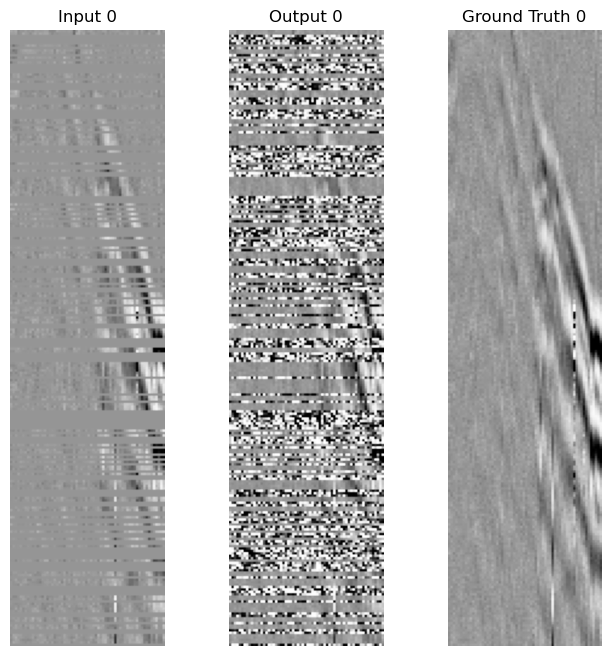

In [14]:
fig, axs = plt.subplots(1,2* num, figsize=(20,8))

max_ = x_start.max()
min_ = x_start.min()
cont = 0
for i in range(num):
    axs[cont].imshow(in_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(out_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Output "+str(i))
    cont = cont+1
    # axs[cont].imshow(truth_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    # axs[cont].set_title("Ground Truth "+str(i))
    # cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]

In [8]:
ds[90][0]

tensor([[[-0.0242,  0.0342,  0.0345,  ...,  0.0398,  0.0731,  0.0526],
         [-0.1117, -0.0565, -0.0710,  ...,  0.3388,  0.2589,  0.0888],
         [ 0.0687,  0.0965,  0.0430,  ..., -0.0325, -0.0526,  0.0616],
         ...,
         [ 0.0129, -0.0416,  0.0339,  ...,  0.0049, -0.0790, -0.0296],
         [-0.0086, -0.0183,  0.0120,  ...,  0.0249, -0.0059,  0.1032],
         [ 0.0045,  0.0400,  0.0921,  ...,  0.1239,  0.0353,  0.0201]]])

[None, None, None, None, None, None, None, None, None, None]

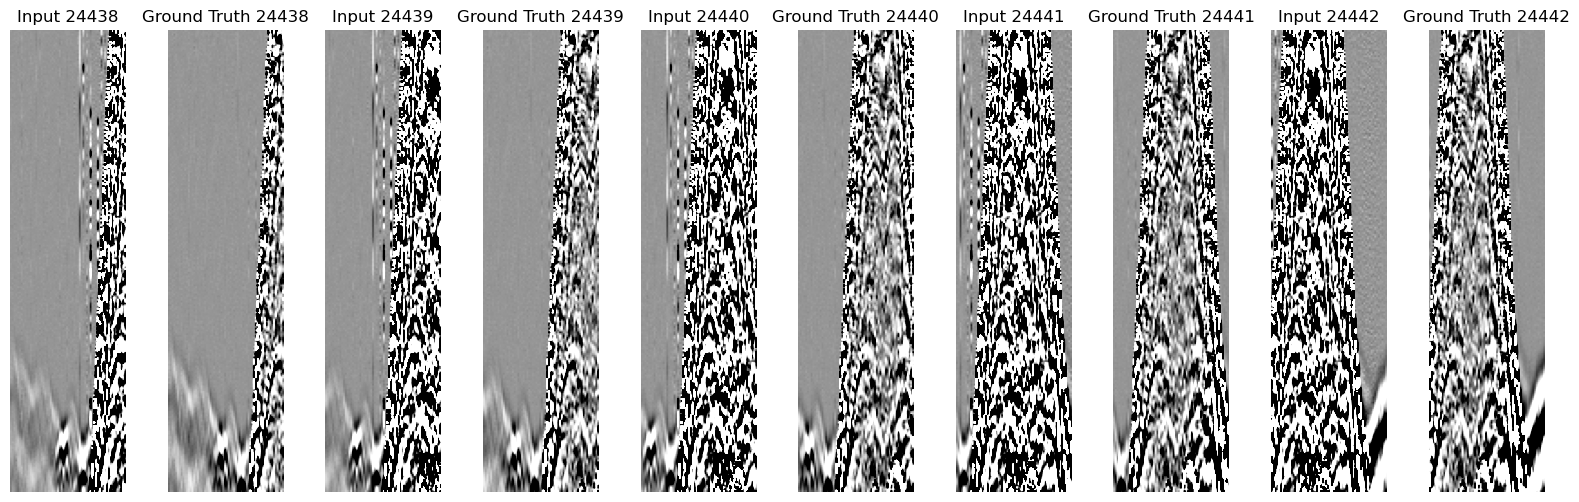

In [139]:
fig, axs = plt.subplots(1,2* num, figsize=(20,6))

n = 21
x0 = 18
y0 = 9

k = x0 + 37 * y0 + 1147 * n
max_ = 2#x_start.max()
min_ = -2#x_start.min()
cont = 0
for j in range(num):
    i = j+k
    axs[cont].imshow(ds[i][0].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(ds[i][1].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Ground Truth "+str(i))
    cont = cont+1
    # axs[cont].imshow(truth_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    # axs[cont].set_title("Ground Truth "+str(i))
    # cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]

----

In [10]:
from torch.utils import data
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [11]:
mode = "demultiple" #demultiple, interpolation, denoising
# folder = './dataset/'+mode+'/data_train/'
folder = 'dataset/'+mode+'/data_test/'

image_size = (64,256)
train_batch_size = 1
    
model = UNet(
        in_channel=2,
        out_channel=1,
        # dropout=0.5,
        image_size = 256,
        # attn_res=[64, 16]
).to("mps")#.cuda()

diffusion = GaussianDiffusion(
    model,
    mode = mode,
    channels = 1,
    image_size = image_size,
    timesteps = 2000,
    loss_type = 'l2', # L1 or L2
    noise_mix_ratio = None
).to("mps")#.cuda()

ds = Dataset(folder, image_size=image_size, mode=mode)
dl = cycle(data.DataLoader(ds, batch_size = train_batch_size, shuffle=False, pin_memory=True))


In [8]:
x_start

tensor([[[[-0.1294, -0.0431, -0.0431,  ..., -0.0353,  0.0353,  0.1216],
          [-0.0510, -0.1294, -0.0745,  ...,  0.0039, -0.1216, -0.0275],
          [-0.0745, -0.0431,  0.0902,  ...,  0.0431, -0.0824,  0.0510],
          ...,
          [ 0.0039, -0.0118,  0.0196,  ...,  0.3020,  0.3412,  0.2627],
          [ 0.0588, -0.0196,  0.0196,  ...,  0.1686,  0.2078,  0.2078],
          [-0.0510,  0.1216, -0.0118,  ...,  0.0118,  0.1686,  0.0824]]]])

In [4]:
for i, (x_in) in enumerate(ds):
    x_start = x_in[0]
    x_start = torch.unsqueeze(x_start, dim=0)
    x_ = x_in[1]
    x_ = torch.unsqueeze(x_, dim=0)

    out = diffusion.inference(x_in=x_start.to("mps"))
    if i == 0: break

sampling loop time step: 100%|██████████| 2000/2000 [01:07<00:00, 29.44it/s]


In [21]:
inputs[0]

tensor([[[-0.1294, -0.0431, -0.0431,  ..., -0.0353,  0.0353,  0.1216],
         [-0.0510, -0.1294, -0.0745,  ...,  0.0039, -0.1216, -0.0275],
         [-0.0745, -0.0431,  0.0902,  ...,  0.0431, -0.0824,  0.0510],
         ...,
         [ 0.0039, -0.0118,  0.0196,  ...,  0.3020,  0.3412,  0.2627],
         [ 0.0588, -0.0196,  0.0196,  ...,  0.1686,  0.2078,  0.2078],
         [-0.0510,  0.1216, -0.0118,  ...,  0.0118,  0.1686,  0.0824]]],
       device='mps:0')

In [23]:
torch.equal(torch.unsqueeze(inputs[0],dim=0), x_start.to("mps"))

True

In [18]:
img = next(dl)
inputs = img[0].to("mps")#.cuda()
out = diffusion.inference(x_in=torch.unsqueeze(inputs[0],dim=0))

sampling loop time step: 100%|██████████| 2000/2000 [01:05<00:00, 30.43it/s]


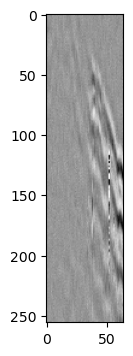

In [5]:
plt.figure(figsize=(1,4))
# plt.imshow(inputs[0,0].cpu().detach().numpy().T, cmap="Greys")
plt.imshow(out[1,0].cpu().detach().numpy().T, cmap="Greys")

----

In [9]:
mode = "interpolation" #demultiple, interpolation, denoising
# folder = './dataset/'+mode+'/data_train/'
folder = 'dataset/'+mode+'/data_test/'

image_size = (64,256)
    
model = UNet(
        in_channel=2,
        out_channel=1
).to("mps")

diffusion = GaussianDiffusion(
    model,
    mode = mode,
    channels = 1,
    image_size = image_size,
    timesteps = 200,
    loss_type = 'l1', # L1 or L2
).to("mps")

ds = Dataset(folder, image_size=image_size, mode=mode)

In [9]:
num = 1
in_samples = np.zeros([num,image_size[0],image_size[1]])
out_samples = np.zeros([num,image_size[0],image_size[1]])
truth_samples = np.zeros([num,image_size[0],image_size[1]])

for i, (x_in) in enumerate(ds):
    x_start = x_in[0]
    x_start = torch.unsqueeze(x_start, dim=0)
    x_ = x_in[1]
    x_ = torch.unsqueeze(x_, dim=0)

    if mode == "interpolation":
        out = diffusion.inference(x_in=x_.to("mps"), mask=x_start.to("mps"))
    else:
        out = diffusion.inference(x_in=x_start.to("mps"))
        

    in_samples[i] = out[0,0].cpu().detach().numpy()
    out_samples[i] = out[1,0].cpu().detach().numpy()
    truth_samples[i] = x_in[1]
    if mode == "interpolation":
        out_samples[i] = out[2,0].cpu().detach().numpy()
    
    if i == num-1:
        break

sampling loop time step:  12%|█▏        | 242/2000 [00:08<01:04, 27.29it/s]


KeyboardInterrupt: 

[None, None, None]

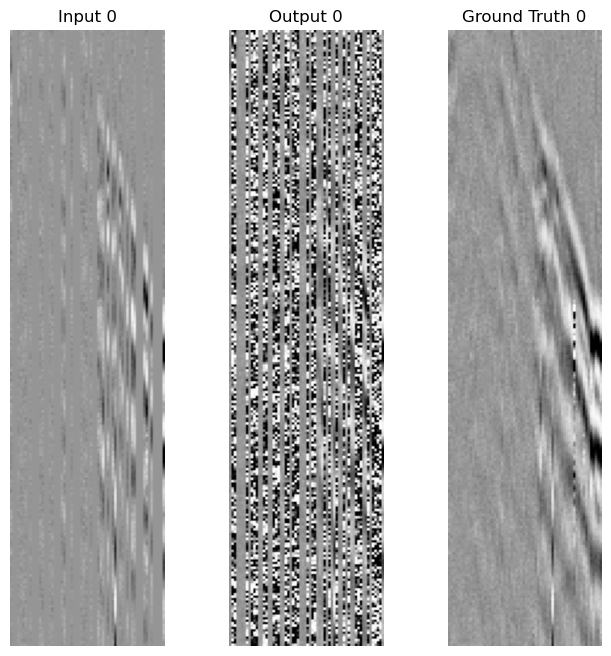

In [12]:
fig, axs = plt.subplots(1,3* num, figsize=(8,8))

max_ = x_start.max()
min_ = x_start.min()
cont = 0
for i in range(num):
    axs[cont].imshow(in_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(out_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Output "+str(i))
    cont = cont+1
    axs[cont].imshow(truth_samples[i].T, vmin=-max_,vmax=max_, cmap="Greys")
    axs[cont].set_title("Ground Truth "+str(i))
    # cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]

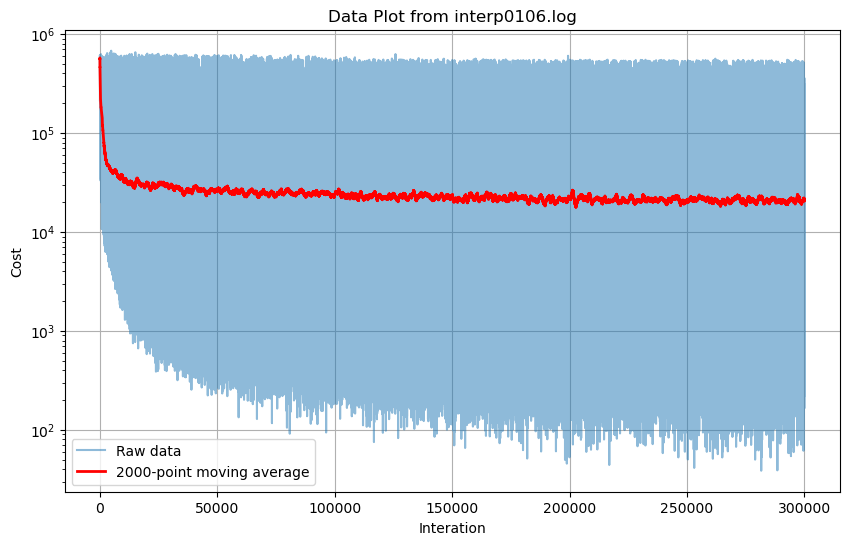

In [29]:
import matplotlib.pyplot as plt
import re

x_values = []
y_values = []

with open("results/demultiple0120-waveform/log.txt", "r") as file:
    for line in file:
        # Skip lines that start with / (warning messages)
        if line.startswith("/"): continue

        # Look for lines with pattern "number: number"
        match = re.match(r"(\d+):\s*([\d.]+)", line.strip())
        if match:
            x_values.append(int(match.group(1)))
            y_values.append(float(match.group(2)))

plt.figure(figsize=(10, 6))
# Calculate moving average
window_size = 2000
moving_avg = []
for i in range(len(y_values)):
    if i < window_size - 1:
        moving_avg.append(sum(y_values[:i+1]) / (i+1))
    else:
        moving_avg.append(sum(y_values[i-window_size+1:i+1]) / window_size)

plt.semilogy(x_values, y_values, alpha=0.5, label='Raw data')
plt.semilogy(x_values, moving_avg, 'r-', linewidth=2, label=f'{window_size}-point moving average')
plt.legend()

plt.xlabel("Interation")
plt.ylabel("Cost")
plt.title("Data Plot from interp0106.log")
plt.grid(True)
plt.show()

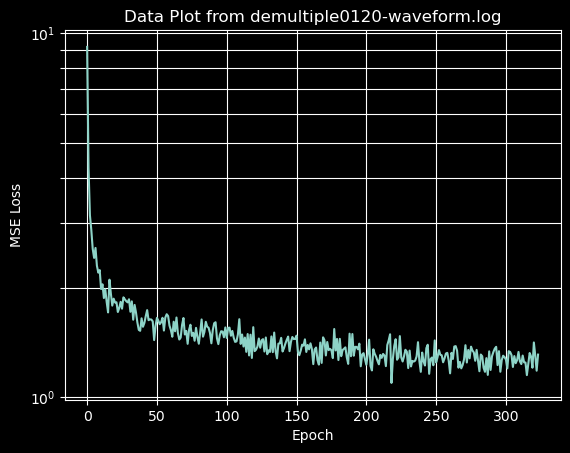

In [32]:
# for i in range(len(y_values)//1850):
#     print(i, )
plt.style.use('dark_background')

plt.semilogy([sum(y_values[i*1850:(i+1)*1850])/1850/256/64 for i in range(len(y_values)//1850)], alpha=1, label='Raw data')
# plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yticks([1,2,3,4,5,6,7,8,9,10])
plt.title("Data Plot from demultiple0120-waveform.log")
plt.grid(True)
plt.show()